In [1]:
import ray
ray.init(address='auto', _redis_password='5241590000000000', ignore_reinit_error=True)

import modin.pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import VarianceThreshold, SelectPercentile, chi2

2021-01-25 08:23:49,851	INFO worker.py:656 -- Connecting to existing Ray cluster at address: 192.168.100.35:6379


In [2]:
dataset = pd.read_csv("/media/kmdr7/Seagate/DATASETS/Processed-Dataset/03-MinMax-02-Null.csv")

x = dataset.drop(columns=["label", "detailed-label"])
y = dataset.label

In [3]:
x.shape

(376829, 80)

# Low Variance + Pearson Correlation Filter

## Menghapus feature yang memiliki low variance

In [10]:
pd.set_option('display.max_rows', 500)
dataset.var().sort_values()

bwd_URG_flag_count          0.000000
fwd_subflow_bytes           0.000003
fwd_bulk_bytes              0.000003
fwd_bulk_packets            0.000003
fwd_pkts_payload.tot        0.000003
bwd_subflow_bytes           0.000003
bwd_subflow_pkts            0.000003
bwd_bulk_bytes              0.000004
bwd_bulk_packets            0.000004
flow_CWR_flag_count         0.000004
active.std                  0.000004
active.avg                  0.000004
bwd_data_pkts_tot           0.000005
bwd_pkts_payload.tot        0.000005
flow_pkts_payload.tot       0.000007
active.max                  0.000007
bwd_PSH_flag_count          0.000008
flow_ECE_flag_count         0.000008
fwd_PSH_flag_count          0.000008
fwd_subflow_pkts            0.000008
fwd_data_pkts_tot           0.000009
fwd_header_size_tot         0.000009
fwd_pkts_tot                0.000010
flow_ACK_flag_count         0.000010
fwd_URG_flag_count          0.000011
bwd_header_size_tot         0.000011
bwd_pkts_tot                0.000011
f

In [11]:
tres = 0.001

lfilter = VarianceThreshold(threshold=tres)
lfilter.fit_transform(x, y)

filtered_cols = x.drop(
    columns=x.columns[lfilter.get_support()].array
).columns.array

lowvariance_dataset = x.drop(columns=filtered_cols)
lowvariance_dataset.shape

(376829, 26)

In [12]:
lowvariance_dataset["label"] = dataset["label"].astype('category').cat.codes
lowvariance_dataset["label"]

0         0
1         0
2         0
3         0
4         0
         ..
376824    1
376825    1
376826    1
376827    1
376828    1
Name: label, Length: 376829, dtype: int8

## Cari korelasi antara fitur dengan target

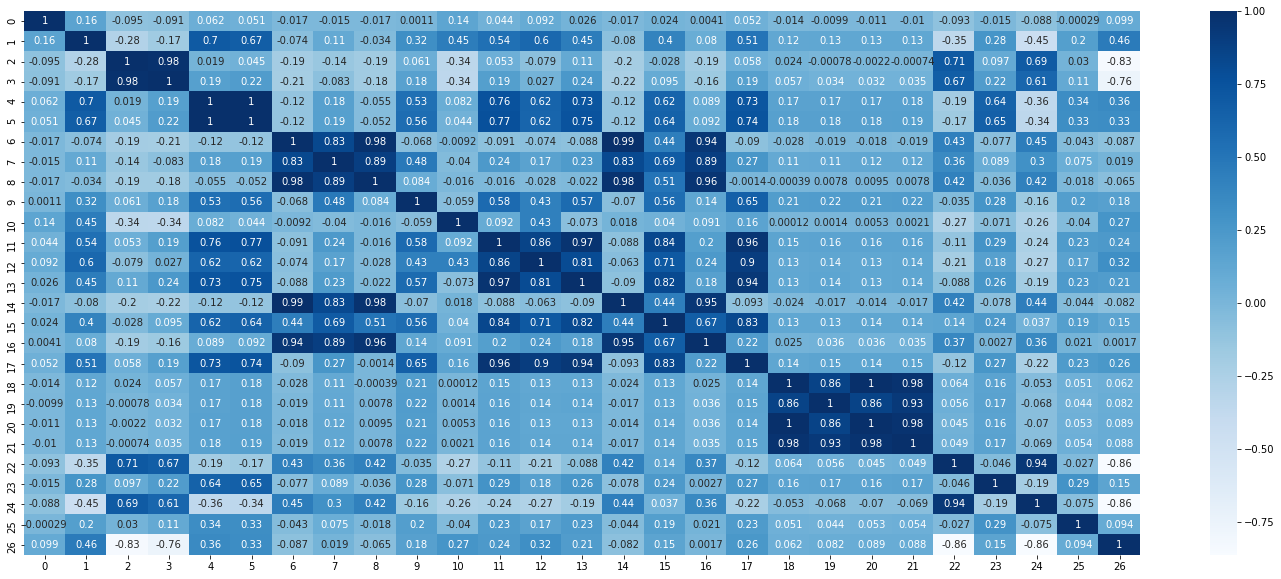

In [13]:
plt.figure(figsize=(25,10))
cor = lowvariance_dataset.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
plt.show()

In [16]:
cor_target = abs(cor["label"])
cor_target.sort_values()

flow_pkts_payload.avg    0.001652
fwd_pkts_payload.max     0.018993
flow_iat.max             0.062204
fwd_pkts_payload.avg     0.065390
idle.min                 0.081716
flow_pkts_payload.min    0.082051
fwd_pkts_payload.min     0.087237
idle.avg                 0.087805
idle.max                 0.089318
bwd_last_window_size     0.094294
bwd_pkts_per_sec         0.098669
bwd_init_window_size     0.153358
flow_pkts_payload.max    0.153776
fwd_pkts_payload.std     0.179840
bwd_pkts_payload.std     0.213832
bwd_pkts_payload.max     0.237727
flow_pkts_payload.std    0.256215
bwd_pkts_payload.min     0.273052
bwd_pkts_payload.avg     0.320498
bwd_header_size_max      0.331566
bwd_header_size_min      0.355672
down_up_ratio            0.464911
fwd_header_size_max      0.760600
fwd_header_size_min      0.834892
fwd_init_window_size     0.860415
fwd_last_window_size     0.863991
label                    1.000000
Name: label, dtype: float64

In [18]:
relevant_features = cor_target[cor_target>=0.06]
relevant_features.sort_values()

flow_iat.max             0.062204
fwd_pkts_payload.avg     0.065390
idle.min                 0.081716
flow_pkts_payload.min    0.082051
fwd_pkts_payload.min     0.087237
idle.avg                 0.087805
idle.max                 0.089318
bwd_last_window_size     0.094294
bwd_pkts_per_sec         0.098669
bwd_init_window_size     0.153358
flow_pkts_payload.max    0.153776
fwd_pkts_payload.std     0.179840
bwd_pkts_payload.std     0.213832
bwd_pkts_payload.max     0.237727
flow_pkts_payload.std    0.256215
bwd_pkts_payload.min     0.273052
bwd_pkts_payload.avg     0.320498
bwd_header_size_max      0.331566
bwd_header_size_min      0.355672
down_up_ratio            0.464911
fwd_header_size_max      0.760600
fwd_header_size_min      0.834892
fwd_init_window_size     0.860415
fwd_last_window_size     0.863991
label                    1.000000
Name: label, dtype: float64

## Hasil lowvariance filter + pearson correlation filter

In [23]:
all_feature = set(dataset.columns)
rel_feature = set(relevant_features.index)

removed_feature = list(all_feature - rel_feature)
removed_feature

lv_cf_dataset = dataset.drop(columns=removed_feature)
lv_cf_dataset

,bwd_pkts_per_sec,down_up_ratio,fwd_header_size_min,fwd_header_size_max,bwd_header_size_min,bwd_header_size_max,fwd_pkts_payload.min,fwd_pkts_payload.avg,fwd_pkts_payload.std,bwd_pkts_payload.min,...,flow_pkts_payload.std,flow_iat.max,idle.min,idle.max,idle.avg,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,bwd_last_window_size,label
0,0.0,0.0,0.909091,0.666667,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.006668,0.0,0.0,0.0,0.445563,0.0,0.445563,0.0,Malicious
1,0.0,0.0,0.909091,0.666667,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.445563,0.0,0.445563,0.0,Malicious
2,0.0,0.0,0.909091,0.666667,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.006668,0.0,0.0,0.0,0.445563,0.0,0.445563,0.0,Malicious
3,0.0,0.0,0.909091,0.666667,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.445563,0.0,0.445563,0.0,Malicious
4,0.0,0.0,0.909091,0.666667,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.006668,0.0,0.0,0.0,0.445563,0.0,0.445563,0.0,Malicious
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376824,0.0,0.0,0.181818,0.133333,0.0,0.0,0.005859,0.005859,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,Benign
376825,0.0,0.0,0.181818,0.133333,0.0,0.0,0.005859,0.005859,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,Benign
376826,0.0,0.0,0.181818,0.133333,0.0,0.0,0.005859,0.005859,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,Benign
376827,0.0,0.0,0.181818,0.133333,0.0,0.0,0.005859,0.005859,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,Benign


In [24]:
lv_cf_dataset.to_csv("/media/kmdr7/Seagate/DATASETS/Processed-Dataset/04-LV-CF-03-MinMax-02-Null.csv", index=False)